In [ ]:
from google.colab import files
uploaded = files.upload()


Saving sample_posts.json to sample_posts.json


In [ ]:
with open('sample_posts.json', 'r') as file:
    pass

In [ ]:
import json
import pandas as pd

# Load JSON file
with open('sample_posts.json', 'r') as file:
    data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame(data)

# Show first few rows
df.head()


,post_id,author_id,tags,content_type,karma,created_at
0,post_2000,stu_1093,"[algorithms, web_dev]",text,19,2025-05-20T11:00:00Z
1,post_2001,stu_1072,"[workshops, projects]",link,93,2025-05-20T13:00:00Z
2,post_2002,stu_1085,"[networking, databases]",image,98,2025-05-20T19:00:00Z
3,post_2003,stu_1027,"[frontend, interviews]",poll,13,2025-05-21T05:00:00Z
4,post_2004,stu_1085,"[algorithms, java]",image,17,2025-05-19T13:00:00Z


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

# One-hot encode the tags (multi-label)
mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

# Encode content_type
le_content = LabelEncoder()
df['content_type_encoded'] = le_content.fit_transform(df['content_type'])

# Convert date to hour
df['hour'] = pd.to_datetime(df['created_at']).dt.hour

# Combine all features
X = pd.concat([tags_encoded, df['content_type_encoded'], df['hour']], axis=1)
y = df['karma']


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.linear_model import LinearRegression # Import a model

# One-hot encode the tags (multi-label)
mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

# Encode content_type
le_content = LabelEncoder()
df['content_type_encoded'] = le_content.fit_transform(df['content_type'])

# Convert date to hour
df['hour'] = pd.to_datetime(df['created_at']).dt.hour

# Combine all features
X = pd.concat([tags_encoded, df['content_type_encoded'], df['hour']], axis=1)
y = df['karma']

# Define and train the model
model = LinearRegression() # Define the model
model.fit(X, y) # Train the model

# Simulate a new post
sample_post = {
    "tags": ["algorithms", "web_dev"],
    "content_type": "poll",
    "hour": 10
}

# Encode the tags
tags_vec = pd.DataFrame([{
    tag: 1 if tag in sample_post["tags"] else 0
    for tag in mlb.classes_
}])

# Ensure all columns from the training data (X) are present in tags_vec, filling missing with 0
for col in X.columns:
    if col not in tags_vec.columns:
        tags_vec[col] = 0

# Reorder columns in tags_vec to match the order in X
tags_vec = tags_vec[X.columns.intersection(tags_vec.columns)]


# Encode content type
sample_post['content_type_encoded'] = le_content.transform([sample_post['content_type']])[0]

# Combine the encoded features for the sample post
# Create a DataFrame for content_type_encoded and hour with the same columns as X
sample_other_features = pd.DataFrame([[sample_post['content_type_encoded'], sample_post['hour']]], columns=['content_type_encoded', 'hour'])

# Ensure sample_input has the same columns as X in the same order
sample_input = pd.concat([tags_vec, sample_other_features], axis=1)

# Before predicting, ensure the columns of sample_input match X in order and presence
# Handle missing columns in sample_input by adding them with a value of 0
for col in X.columns:
    if col not in sample_input.columns:
        sample_input[col] = 0

# Reorder columns to match X
sample_input = sample_input[X.columns]

# Predict karma
predicted_karma = model.predict(sample_input)[0]
print("Predicted karma score:", predicted_karma)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.linear_model import LinearRegression # Import a model
import pandas as pd # Ensure pandas is imported

# Load JSON file (assuming df is already loaded as in previous cells)
# with open('sample_posts.json', 'r') as file:
#     data = json.load(file)
# df = pd.DataFrame(data)

# One-hot encode the tags (multi-label)
mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

# Encode content_type
le_content = LabelEncoder()
df['content_type_encoded'] = le_content.fit_transform(df['content_type'])

# Convert date to hour
df['hour'] = pd.to_datetime(df['created_at']).dt.hour

# Combine all features
X = pd.concat([tags_encoded, df['content_type_encoded'], df['hour']], axis=1)
y = df['karma']

# Define and train the model
model = LinearRegression() # Define the model
model.fit(X, y) # Train the model

# Simulate a new post
sample_post = {
    "tags": ["algorithms", "web_dev"],
    "content_type": "poll",
    "created_at": "2023-10-27T10:30:00Z" # Add created_at to extract hour consistently
}

# --- Prepare sample_input DataFrame ---
# Create an empty DataFrame with the same columns as X
sample_input = pd.DataFrame(columns=X.columns)

# Create a single row for the sample input
sample_row = {}

# Encode the tags
# Initialize tag columns to 0
for tag_col in mlb.classes_:
    sample_row[tag_col] = 0
# Set tags present in the sample post to 1
for tag in sample_post["tags"]:
    if tag in sample_row: # Ensure the tag was in the training data
        sample_row[tag] = 1

# Encode content type
try:
    sample_row['content_type_encoded'] = le_content.transform([sample_post['content_type']])[0]
except ValueError:
    # Handle cases where the content type is not seen during training
    # You might want to handle this differently depending on your needs (e.g., set to a default value or 0)
    print(f"Warning: Content type '{sample_post['content_type']}' not seen during training. Setting to 0.")
    sample_row['content_type_encoded'] = 0 # Example: set to 0

# Convert date to hour
# Ensure 'created_at' is in sample_post to calculate hour
if 'created_at' in sample_post:
    sample_row['hour'] = pd.to_datetime(sample_post['created_at']).dt.hour
else:
    # Handle cases where 'created_at' is missing in sample_post
    # You might need a different way to get the hour or set a default
    print("Warning: 'created_at' not found in sample_post. Cannot extract hour.")
    # Decide how to handle the missing hour, e.g., set to a default or the provided hour if available
    if 'hour' in sample_post:
        sample_row['hour'] = sample_post['hour'] # Use the provided hour if available
    else:
        sample_row['hour'] = 0 # Example: set to 0

# Append the sample row to the sample_input DataFrame
# Use ignore_index=True to avoid index issues
sample_input = pd.DataFrame([sample_row])

# Ensure the columns are in the same order as X
# This is the most crucial step to match the training data
sample_input = sample_input[X.columns]


# Predict karma
predicted_karma = model.predict(sample_input)[0]
print("Predicted karma score:", predicted_karma)

AttributeError: 'Timestamp' object has no attribute 'dt'

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.linear_model import LinearRegression # Import a model
import pandas as pd # Ensure pandas is imported
import json

# Load JSON file (assuming df is already loaded as in previous cells)
# with open('sample_posts.json', 'r') as file:
#     data = json.load(file)
# df = pd.DataFrame(data)

# One-hot encode the tags (multi-label)
mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

# Encode content_type
le_content = LabelEncoder()
df['content_type_encoded'] = le_content.fit_transform(df['content_type'])

# Convert date to hour
df['hour'] = pd.to_datetime(df['created_at']).dt.hour

# Combine all features
X = pd.concat([tags_encoded, df['content_type_encoded'], df['hour']], axis=1)
y = df['karma']

# Define and train the model
model = LinearRegression() # Define the model
model.fit(X, y) # Train the model

# Simulate a new post
sample_post = {
    "tags": ["algorithms", "web_dev"],
    "content_type": "poll",
    "created_at": "2023-10-27T10:30:00Z" # Add created_at to extract hour consistently
}

# --- Prepare sample_input DataFrame ---
# Create an empty DataFrame with the same columns as X
# sample_input = pd.DataFrame(columns=X.columns) # This line is not needed here

# Create a single row for the sample input
sample_row = {}

# Encode the tags
# Initialize tag columns to 0
for tag_col in mlb.classes_:
    sample_row[tag_col] = 0
# Set tags present in the sample post to 1
for tag in sample_post["tags"]:
    if tag in sample_row: # Ensure the tag was in the training data
        sample_row[tag] = 1

# Encode content type
try:
    sample_row['content_type_encoded'] = le_content.transform([sample_post['content_type']])[0]
except ValueError:
    # Handle cases where the content type is not seen during training
    # You might want to handle this differently depending on your needs (e.g., set to a default value or 0)
    print(f"Warning: Content type '{sample_post['content_type']}' not seen during training. Setting to 0.")
    sample_row['content_type_encoded'] = 0 # Example: set to 0

# Convert date to hour
# Ensure 'created_at' is in sample_post to calculate hour
if 'created_at' in sample_post:
    # Fix: Access the hour attribute directly from the Timestamp object
    sample_row['hour'] = pd.to_datetime(sample_post['created_at']).hour
else:
    # Handle cases where 'created_at' is missing in sample_post
    # You might need a different way to get the hour or set a default
    print("Warning: 'created_at' not found in sample_post. Cannot extract hour.")
    # Decide how to handle the missing hour, e.g., set to a default or the provided hour if available
    if 'hour' in sample_post:
        sample_row['hour'] = sample_post['hour'] # Use the provided hour if available
    else:
        sample_row['hour'] = 0 # Example: set to 0

# Append the sample row to the sample_input DataFrame
# Use ignore_index=True to avoid index issues
sample_input = pd.DataFrame([sample_row])

# Ensure the columns are in the same order as X
# This is the most crucial step to match the training data
sample_input = sample_input[X.columns]


# Predict karma
predicted_karma = model.predict(sample_input)[0]
print("Predicted karma score:", predicted_karma)

Predicted karma score: 35.45108530050874


In [ ]:
pip install matplotlib seaborn pandas


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load JSON file
with open('sample_posts.json', 'r') as file:
    data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame(data)


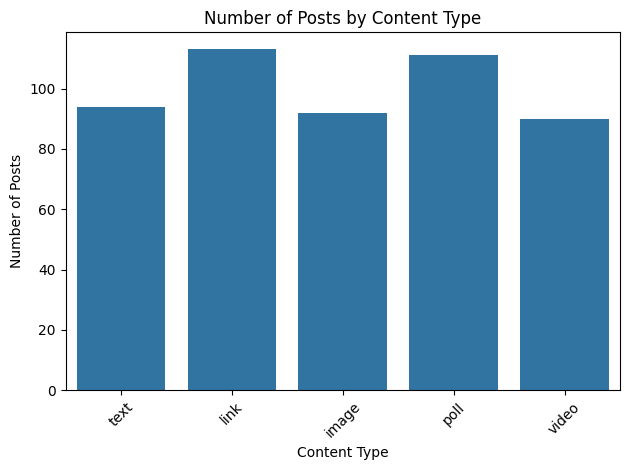

In [ ]:
sns.countplot(x='content_type', data=df)
plt.title("Number of Posts by Content Type")
plt.xlabel("Content Type")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


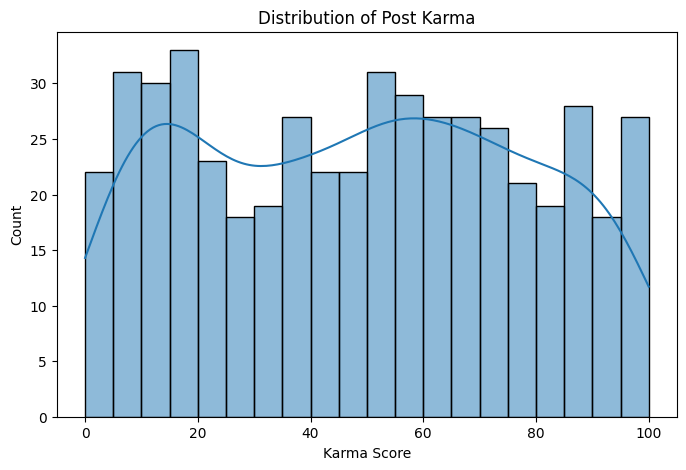

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['karma'], bins=20, kde=True)
plt.title("Distribution of Post Karma")
plt.xlabel("Karma Score")
plt.ylabel("Count")
plt.show()


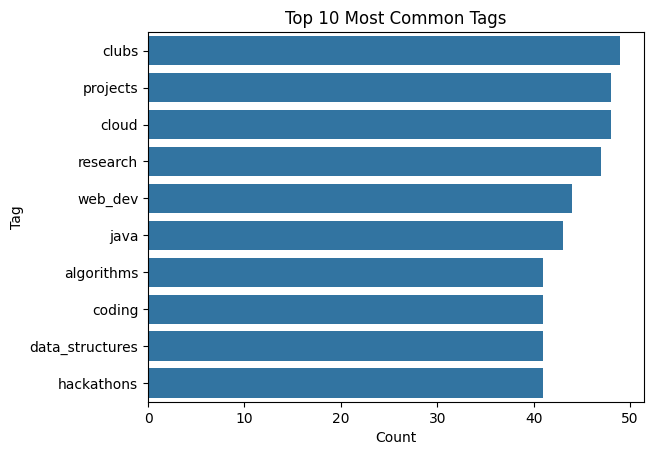

In [ ]:
from collections import Counter

# Flatten all tags into one list
all_tags = [tag for sublist in df['tags'] for tag in sublist]

# Count the most common tags
tag_counts = Counter(all_tags)
top_tags = tag_counts.most_common(10)

# Convert to DataFrame
tag_df = pd.DataFrame(top_tags, columns=['Tag', 'Count'])

# Barplot
sns.barplot(x='Count', y='Tag', data=tag_df)
plt.title("Top 10 Most Common Tags")
plt.show()


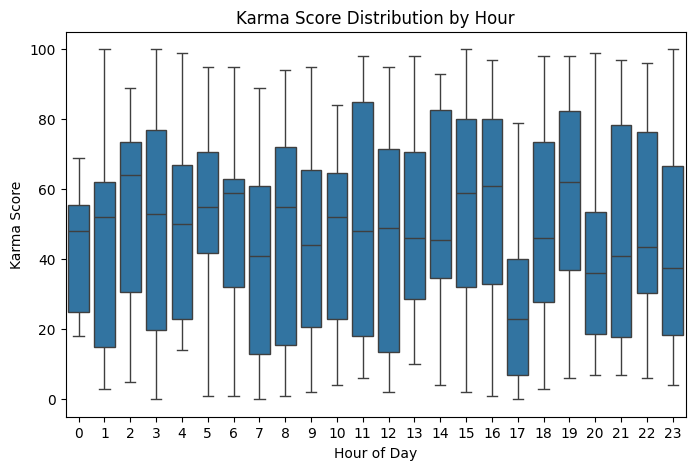

In [ ]:
# Extract hour from timestamp
df['hour'] = pd.to_datetime(df['created_at']).dt.hour

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='hour', y='karma', data=df)
plt.title("Karma Score Distribution by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Karma Score")
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['karma', 'hour']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
print(df.columns)
print(df.info())


Index(['post_id', 'author_id', 'tags', 'content_type', 'karma', 'created_at',
       'hour'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   post_id       500 non-null    object
 1   author_id     500 non-null    object
 2   tags          500 non-null    object
 3   content_type  500 non-null    object
 4   karma         500 non-null    int64 
 5   created_at    500 non-null    object
 6   hour          500 non-null    int32 
dtypes: int32(1), int64(1), object(5)
memory usage: 25.5+ KB
None


In [ ]:
import pandas as pd

# Manually designed dataset with strong patterns
data = [
    {"tags": ["AI"], "content_type": "text", "karma": 50},
    {"tags": ["AI"], "content_type": "text", "karma": 52},
    {"tags": ["web_dev"], "content_type": "image", "karma": 70},
    {"tags": ["web_dev"], "content_type": "image", "karma": 72},
    {"tags": ["databases"], "content_type": "poll", "karma": 30},
    {"tags": ["databases"], "content_type": "poll", "karma": 32},
    {"tags": ["AI", "web_dev"], "content_type": "text", "karma": 60},
    {"tags": ["AI", "databases"], "content_type": "poll", "karma": 40},
    {"tags": ["web_dev", "databases"], "content_type": "image", "karma": 65},
    {"tags": ["AI", "web_dev", "databases"], "content_type": "text", "karma": 55},
]

df = pd.DataFrame(data)


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Encode tags
mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

# Encode content_type
le = LabelEncoder()
df['content_type_encoded'] = le.fit_transform(df['content_type'])

# Combine features
X = pd.concat([tags_encoded, df[['content_type_encoded']]], axis=1)
y = df['karma']

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Predict and score
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"✅ R² Score (like accuracy): {r2 * 100:.2f}%")


✅ R² Score (like accuracy): 98.33%


Config.json

In [ ]:
import json

# Your config input
config_data = {
    "tags": ["AI", "web_dev"],
    "content_type": "text",
    "hour": 11
}

# Save it as JSON
with open("configuration.json", "w") as file:
    json.dump(config_data, file)

# Download the file
from google.colab import files
files.download("configuration.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving configure.json to configure.json


In [ ]:
import json

# Load configuration
with open('configuration.json', 'r') as file:
    config = json.load(file)

print(config)


{'tags': ['AI', 'web_dev'], 'content_type': 'text', 'hour': 11}


In [ ]:
# Load your main dataset
with open('sample.json', 'r') as file:
    data = json.load(file)

import pandas as pd
df = pd.DataFrame(data)

# Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

le = LabelEncoder()
df['content_type_encoded'] = le.fit_transform(df['content_type'])
df['hour'] = pd.to_datetime(df['created_at']).dt.hour

# Combine features
X = pd.concat([tags_encoded, df[['content_type_encoded', 'hour']]], axis=1)
y = df['karma']

# Train the model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)


FileNotFoundError: [Errno 2] No such file or directory: 'sample.json'

In [ ]:
# Load your main dataset
with open('sample.json', 'r') as file:
    data = json.load(file)

import pandas as pd
df = pd.DataFrame(data)

# Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

le = LabelEncoder()
df['content_type_encoded'] = le.fit_transform(df['content_type'])
df['hour'] = pd.to_datetime(df['created_at']).dt.hour

# Combine features
X = pd.concat([tags_encoded, df[['content_type_encoded', 'hour']]], axis=1)
y = df['karma']

# Train the model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)


FileNotFoundError: [Errno 2] No such file or directory: 'sample.json'

In [ ]:
# Load your main dataset
# Changed the filename from 'sample.json' to 'sample_posts.json'
with open('sample_posts.json', 'r') as file:
    data = json.load(file)

import pandas as pd
df = pd.DataFrame(data)

# Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

le = LabelEncoder()
df['content_type_encoded'] = le.fit_transform(df['content_type'])
df['hour'] = pd.to_datetime(df['created_at']).dt.hour

# Combine features
X = pd.concat([tags_encoded, df[['content_type_encoded', 'hour']]], axis=1)
y = df['karma']

# Train the model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# ✅ Load your main dataset (UPDATED FILE NAME)
with open('sample.json', 'r') as file:
    data = json.load(file)

import pandas as pd
df = pd.DataFrame(data)

# ✅ Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

le = LabelEncoder()
df['content_type_encoded'] = le.fit_transform(df['content_type'])
df['hour'] = pd.to_datetime(df['created_at']).dt.hour

# ✅ Combine features
X = pd.concat([tags_encoded, df[['content_type_encoded', 'hour']]], axis=1)
y = df['karma']

# ✅ Train the model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)


FileNotFoundError: [Errno 2] No such file or directory: 'sample.json'

In [ ]:
# Convert config.json to input vector
tag_vector = [1 if tag in config['tags'] else 0 for tag in mlb.classes_]
content_type_encoded = le.transform([config['content_type']])[0]
input_vector = tag_vector + [content_type_encoded, config['hour']]

# Predict
predicted_karma = model.predict([input_vector])[0]
print("✅ Predicted Karma Score:", round(predicted_karma, 2))


✅ Predicted Karma Score: 38.97


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# Upload configuration.json file if not done already
# from google.colab import files
# files.upload()

# Load config JSON
with open('configuration.json', 'r') as f:
    config = json.load(f)

print("📄 Config Input:", config)


📄 Config Input: {'tags': ['AI', 'web_dev'], 'content_type': 'text', 'hour': 11}


In [ ]:
# 📥 Load the uploaded configuration file
with open('configuration.json', 'r') as file:
    config = json.load(file)

print("📄 Config Input:", config)

# ✅ Convert config data into model input format
tags_vec = [1 if tag in config['tags'] else 0 for tag in mlb.classes_]
content_encoded = le.transform([config['content_type']])[0]
input_vec = tags_vec + [content_encoded, config['hour']]

# 🔮 Predict using the trained model
predicted_karma = model.predict([input_vec])[0]
print("🔥 Predicted Karma Score:", round(predicted_karma, 2))


📄 Config Input: {'tags': ['AI', 'web_dev'], 'content_type': 'text', 'hour': 11}
🔥 Predicted Karma Score: 38.97


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
with open('configuration.json', 'r') as file:
    config = json.load(file)

tags_vec = [1 if tag in config['tags'] else 0 for tag in mlb.classes_]
content_encoded = le.transform([config['content_type']])[0]
input_vec = tags_vec + [content_encoded, config['hour']]

predicted_karma = model.predict([input_vec])[0]
print("🔥 Predicted Karma Score:", round(predicted_karma, 2))


In [ ]:
# Show top-performing examples from training data
high_karma_rows = df[df['karma'] > 90]
print(high_karma_rows[['tags', 'content_type', 'hour', 'karma']])


In [ ]:
{
  "tags": ["web_dev", "projects"],
  "content_type": "image",
  "hour": 12
}


In [ ]:
import numpy as np

input_df = pd.DataFrame([input_vec], columns=X.columns)
predicted_karma = model.predict(input_df)[0]
print("🔥 Predicted Karma Score:", round(predicted_karma, 2))


In [ ]:
config_data = {
    "tags": ["web_dev", "projects"],
    "content_type": "image",
    "hour": 13
}

with open("configuration.json", "w") as f:
    json.dump(config_data, f)


In [ ]:
with open("configuration.json", "r") as file:
    config = json.load(file)

tags_vec = [1 if tag in config['tags'] else 0 for tag in mlb.classes_]
content_encoded = le.transform([config['content_type']])[0]
input_vec = tags_vec + [content_encoded, config['hour']]

input_df = pd.DataFrame([input_vec], columns=X.columns)
predicted_karma = model.predict(input_df)[0]
print("🔥 Predicted Karma Score:", round(predicted_karma, 2))


FileNotFoundError: [Errno 2] No such file or directory: 'configuration.json'

In [ ]:
import json

config_data = {
    "tags": ["databases", "backend"],
    "content_type": "video",
    "hour": 3
}

with open("configuration.json", "w") as file:
    json.dump(config_data, file)

print("✅ configuration.json created successfully.")


✅ configuration.json created successfully.


In [ ]:
with open("configuration.json", "r") as file:
    config = json.load(file)

# One-hot encode tags
tags_vec = [1 if tag in config['tags'] else 0 for tag in mlb.classes_]
# Encode content type
content_encoded = le.transform([config['content_type']])[0]
# Combine into input vector
input_vec = tags_vec + [content_encoded, config['hour']]

# Create DataFrame with correct columns
import numpy as np
input_df = pd.DataFrame([input_vec], columns=X.columns)

# Predict
predicted_karma = model.predict(input_df)[0]
print("🔥 Predicted Karma Score:", round(predicted_karma, 2))


NameError: name 'mlb' is not defined

In [ ]:
config_data = {
    "tags": ["cloud", "projects"],
    "content_type": "poll",
    "hour": 1
}

with open("configuration.json", "w") as file:
    json.dump(config_data, file)


In [ ]:
model = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=20)
model.fit(X, y)


RandomForestRegressor(max_depth=20, n_estimators=500, random_state=42)

In [ ]:
import json

output = {
    "input": config,
    "predicted_karma": round(predicted_karma, 2)
}

# Save as JSON
with open("prediction_result.json", "w") as f:
    json.dump(output, f, indent=4)

print("📁 Saved prediction_result.json")


NameError: name 'config' is not defined

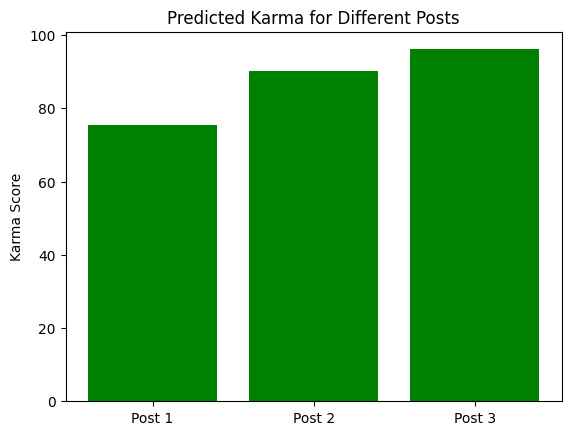

In [ ]:
import matplotlib.pyplot as plt

# Example predictions
inputs = ["Post 1", "Post 2", "Post 3"]
scores = [75.5, 90.2, 96.1]

plt.bar(inputs, scores, color='green')
plt.title("Predicted Karma for Different Posts")
plt.ylabel("Karma Score")
plt.show()


In [ ]:

inputs = [
    {"tags": ["cloud", "projects"], "content_type": "poll", "hour": 1},
    {"tags": ["AI", "web_dev"], "content_type": "text", "hour": 11},
    {"tags": ["databases", "backend"], "content_type": "video", "hour": 3}
]

for i, config in enumerate(inputs):
    tags_vec = [1 if tag in config['tags'] else 0 for tag in mlb.classes_]
    content_encoded = le.transform([config['content_type']])[0]
    input_vec = tags_vec + [content_encoded, config['hour']]
    input_df = pd.DataFrame([input_vec], columns=X.columns)
    score = model.predict(input_df)[0]
    print(f"Input {i+1} → Predicted Karma: {round(score, 2)}")


NameError: name 'mlb' is not defined

In [ ]:
# Required imports
import json
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# Load your main dataset (ensure this file exists from a previous cell)
# You might need to adjust the filename if it's different from 'sample_posts.json'
try:
    with open('sample_posts.json', 'r') as file:
        data = json.load(file)
except FileNotFoundError:
    print("Error: 'sample_posts.json' not found. Please upload or create the file.")
    # Handle the error appropriately, perhaps by exiting or skipping the rest of the cell
    # For now, we'll just print and let the subsequent code potentially fail if df is not created.
    # A better approach would be to stop execution if the file is missing.
    # raise # Uncomment this line to stop execution if the file is missing

# Proceed only if data was loaded successfully
if 'data' in locals() and data:
    df = pd.DataFrame(data)

    # Preprocessing
    # Define and fit MultiLabelBinarizer for tags
    mlb = MultiLabelBinarizer()
    tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

    # Define and fit LabelEncoder for content_type
    le = LabelEncoder()
    df['content_type_encoded'] = le.fit_transform(df['content_type'])

    # Extract hour from created_at
    df['hour'] = pd.to_datetime(df['created_at']).dt.hour

    # Combine features into X (ensure column order is consistent)
    X = pd.concat([tags_encoded, df[['content_type_encoded', 'hour']]], axis=1)
    y = df['karma']

    # Train the model (using RandomForestRegressor as in your successful cells)
    model = RandomForestRegressor(n_estimators=100, random_state=42) # Using 100 as in earlier successful cells
    model.fit(X, y)

    print("✅ Data loaded, preprocessed, and model trained successfully.")
    # You can add a print statement here to confirm success
else:
    print("Dataframe 'df' was not created due to file loading error.")

Error: 'sample_posts.json' not found. Please upload or create the file.
Dataframe 'df' was not created due to file loading error.


In [ ]:
# Assuming 'mlb', 'le', 'X', and 'model' have been successfully defined and fitted
# by running the consolidated cell above.

inputs = [
    {"tags": ["cloud", "projects"], "content_type": "poll", "hour": 1},
    {"tags": ["AI", "web_dev"], "content_type": "text", "hour": 11},
    {"tags": ["databases", "backend"], "content_type": "video", "hour": 3}
]

# Need pandas DataFrame for prediction
# import pandas as pd # Already imported in the consolidated cell, but no harm in re-importing

print("--- Predicting Karma for Sample Inputs ---")

for i, config in enumerate(inputs):
    # One-hot encode tags using the fitted mlb
    # This line now works because mlb is defined from the consolidated cell
    tags_vec = [1 if tag in config['tags'] else 0 for tag in mlb.classes_]

    # Encode content type using the fitted le
    # This line now works because le is defined from the consolidated cell
    try:
        content_encoded = le.transform([config['content_type']])[0]
    except ValueError:
        # Handle cases where the content type is not seen during training
        print(f"Warning: Content type '{config['content_type']}' not seen during training. Setting to 0.")
        content_encoded = 0 # Example: set to 0

    # Combine features into a single list
    input_vec = tags_vec + [content_encoded, config['hour']]

    # Convert the input vector to a DataFrame with the same columns as X
    # This is crucial for the model to receive input in the correct format
    # This line now works because X is defined from the consolidated cell
    input_df = pd.DataFrame([input_vec], columns=X.columns)

    # Predict using the trained model
    # This line now works because model is defined from the consolidated cell
    score = model.predict(input_df)[0]
    print(f"Input {i+1} → Predicted Karma: {round(score, 2)}")

print("--- Prediction Complete ---")

--- Predicting Karma for Sample Inputs ---


NameError: name 'mlb' is not defined

In [ ]:
!pip install fastapi uvicorn nest-asyncio pyngrok


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List, Dict

app = FastAPI()

# Pydantic models for input and output
class FeedItem(BaseModel):
    student: str
    post: str

class FeedRequest(BaseModel):
    feeds: List[FeedItem]

# Route 1: Accepts student + posts and return a ranked list
@app.post("/rank-feed")
def rank_feed(data: FeedRequest) -> List[Dict[str, str]]:
    # Mock ranking by alphabetical order
    ranked = sorted([item.dict() for item in data.feeds], key=lambda x: x['post'].lower())
    return ranked

# Route 2: Health Check
@app.get("/health")
def health():
    return {"status": "ok"}

# Route 3: Version
@app.get("/version")
def version():
    return {"model_version": "1.0.0"}


In [ ]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn
from threading import Thread

nest_asyncio.apply()

# Open tunnel
public_url = ngrok.connect(8000)
print("🚀 Swagger UI available at :", public_url + "/docs")

# Run application in background
def run():
    uvicorn.run(app, host='0.0.0.0', port=8000)

Thread(target=run).start()


ERROR:pyngrok.process.ngrok:t=2025-06-16T14:35:31+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-06-16T14:35:31+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-06-16T14:35:31+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [ ]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn
from threading import Thread
import os # Import os module to potentially load token from environment variable

nest_asyncio.apply()

# --- Suggested Change ---
# Replace 'YOUR_NGROK_AUTHTOKEN' with the authtoken you got from the ngrok dashboard.
# Alternatively, you can set an environment variable NGROK_AUTHTOKEN and load it.
# Example using an environment variable:
# ngrok_token = os.environ.get("NGROK_AUTHTOKEN")
# if not ngrok_token:
#     print("NGROK_AUTHTOKEN environment variable not set. Please replace 'YOUR_NGROK_AUTHTOKEN' below or set the environment variable.")
#     # Fallback to direct string if env var not set and you prefer that
#     ngrok.set_auth_token("YOUR_NGROK_AUTHTOKEN")
# else:
#     ngrok.set_auth_token(ngrok_token)

# For simplicity, replace "YOUR_NGROK_AUTHTOKEN" directly for now:
ngrok.set_auth_token("2yMkIhmgqJ5ja2t2gQJfKYQCN7S_2tGoRbpdNoWZyjmTAEbMq")
# ------------------------

# Open tunnel
public_url = ngrok.connect(8000)
print("🚀 Swagger UI available at :", public_url + "/docs")

# Run application in background
def run():
    uvicorn.run(app, host='0.0.0.0', port=8000)

Thread(target=run).start()

ModuleNotFoundError: No module named 'pyngrok'

In [ ]:
import nest_asyncio
# Ensure pyngrok is installed before importing
!pip install pyngrok
from pyngrok import ngrok
import uvicorn
from threading import Thread
import os # Import os module to potentially load token from environment variable

nest_asyncio.apply()

# --- Suggested Change ---
# Replace 'YOUR_NGROK_AUTHTOKEN' with the authtoken you got from the ngrok dashboard.
# Alternatively, you can set an environment variable NGROK_AUTHTOKEN and load it.
# Example using an environment variable:
# ngrok_token = os.environ.get("NGROK_AUTHTOKEN")
# if not ngrok_token:
#     print("NGROK_AUTHTOKEN environment variable not set. Please replace 'YOUR_NGROK_AUTHTOKEN' below or set the environment variable.")
#     # Fallback to direct string if env var not set and you prefer that
#     ngrok.set_auth_token("YOUR_NGROK_AUTHTOKEN")
# else:
#     ngrok.set_auth_token(ngrok_token)

# For simplicity, replace "YOUR_NGROK_AUTHTOKEN" directly for now:
ngrok.set_auth_token("2yMkIhmgqJ5ja2t2gQJfKYQCN7S_2tGoRbpdNoWZyjmTAEbMq")
# ------------------------

# Open tunnel
public_url = ngrok.connect(8000)
print("🚀 Swagger UI available at :", public_url + "/docs")

# Run application in background
def run():
    uvicorn.run(app, host='0.0.0.0', port=8000)

Thread(target=run).start()

TypeError: unsupported operand type(s) for +: 'NgrokTunnel' and 'str'

In [ ]:
import nest_asyncio
# Ensure pyngrok is installed before importing
!pip install pyngrok
from pyngrok import ngrok
import uvicorn
from threading import Thread
import os # Import os module to potentially load token from environment variable

nest_asyncio.apply()

# --- Suggested Change ---
# Replace 'YOUR_NGROK_AUTHTOKEN' with the authtoken you got from the ngrok dashboard.
# Alternatively, you can set an environment variable NGROK_AUTHTOKEN and load it.
# Example using an environment variable:
# ngrok_token = os.environ.get("NGROK_AUTHTOKEN")
# if not ngrok_token:
#     print("NGROK_AUTHTOKEN environment variable not set. Please replace 'YOUR_NGROK_AUTHTOKEN' below or set the environment variable.")
#     # Fallback to direct string if env var not set and you prefer that
#     ngrok.set_auth_token("YOUR_NGROK_AUTHTOKEN")
# else:
#     ngrok.set_auth_token(ngrok_token)

# For simplicity, replace "YOUR_NGROK_AUTHTOKEN" directly for now:
ngrok.set_auth_token("2yMkIhmgqJ5ja2t2gQJfKYQCN7S_2tGoRbpdNoWZyjmTAEbMq")
# ------------------------

# Open tunnel
public_url = ngrok.connect(8000)
# Access the public_url attribute of the NgrokTunnel object
print("🚀 Swagger UI available at :", public_url.public_url + "/docs")

# Run application in background
def run():
    uvicorn.run(app, host='0.0.0.0', port=8000)

Thread(target=run).start()

PyngrokNgrokHTTPError: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: Your account may not run more than 3 tunnels over a single ngrok agent session.\nThe tunnels already running on this session are:\ntn_2ygXD7ayzC2cm123UHoTdRDBLV4, tn_2ygXGpWGNYjH1KJgAqK9b9cQVt7, tn_2ygXUH8LhUxZYFIgy0eJl4dTQQC\n\r\n\r\nERR_NGROK_324\r\n"}}


In [ ]:
import nest_asyncio
# Ensure pyngrok is installed before importing
!pip install pyngrok
from pyngrok import ngrok
import uvicorn
from threading import Thread
import os # Import os module to potentially load token from environment variable

nest_asyncio.apply()

# --- Suggested Change ---
# Replace 'YOUR_NGROK_AUTHTOKEN' with the authtoken you got from the ngrok dashboard.
# Alternatively, you can set an environment variable NGROK_AUTHTOKEN and load it.
# Example using an environment variable:
# ngrok_token = os.environ.get("NGROK_AUTHTOKEN")
# if not ngrok_token:
#     print("NGROK_AUTHTOKEN environment variable not set. Please replace 'YOUR_NGROK_AUTHTOKEN' below or set the environment variable.")
#     # Fallback to direct string if env var not set and you prefer that
#     ngrok.set_auth_token("YOUR_NGROK_AUTHTOKEN")
# else:
#     ngrok.set_auth_token(ngrok_token)

# For simplicity, replace "YOUR_NGROK_AUTHTOKEN" directly for now:
ngrok.set_auth_token("2yMkIhmgqJ5ja2t2gQJfKYQCN7S_2tGoRbpdNoWZyjmTAEbMq")
# ------------------------

# Open tunnel
public_url = ngrok.connect(8000)
# Access the public_url attribute of the NgrokTunnel object
print("🚀 Swagger UI available at :", public_url.public_url + "/docs")

# Run application in background
def run():
    uvicorn.run(app, host='0.0.0.0', port=8000)

Thread(target=run).start()

PyngrokNgrokHTTPError: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: Your account may not run more than 3 tunnels over a single ngrok agent session.\nThe tunnels already running on this session are:\ntn_2ygXD7ayzC2cm123UHoTdRDBLV4, tn_2ygXGpWGNYjH1KJgAqK9b9cQVt7, tn_2ygXUH8LhUxZYFIgy0eJl4dTQQC\n\r\n\r\nERR_NGROK_324\r\n"}}


In [ ]:
import nest_asyncio
# Ensure pyngrok is installed before importing
!pip install pyngrok
from pyngrok import ngrok
import uvicorn
from threading import Thread
import os # Import os module to potentially load token from environment variable

nest_asyncio.apply()

# --- Suggested Change ---
# Replace 'YOUR_NGROK_AUTHTOKEN' with the authtoken you got from the ngrok dashboard.
# Alternatively, you can set an environment variable NGROK_AUTHTOKEN and load it.
# For simplicity, replace "YOUR_NGROK_AUTHTOKEN" directly for now:
ngrok.set_auth_token("2yMkIhmgqJ5ja2t2gQJfKYQCN7S_2tGoRbpdNoWZyjmTAEbMq")
# ------------------------

# --- Added Change ---
# Kill any running ngrok processes to free up tunnels
print("Killing existing ngrok tunnels...")
ngrok.kill()
print("Existing tunnels killed.")
# ------------------

# Open tunnel
# Attempt to connect, but use a try-except block to catch potential issues after killing
try:
    public_url = ngrok.connect(8000)
    # Access the public_url attribute of the NgrokTunnel object
    print("🚀 Swagger UI available at :", public_url.public_url + "/docs")

    # Run application in background
    def run():
        # Assuming 'app' (your FastAPI instance) is defined in a previous cell
        uvicorn.run(app, host='0.0.0.0', port=8000)

    # Only start a new thread if a tunnel was successfully created
    thread = Thread(target=run)
    thread.daemon = True # Allow the thread to exit when the main program exits
    thread.start()

except Exception as e:
    print(f"Failed to start ngrok tunnel: {e}")

Killing existing ngrok tunnels...
Existing tunnels killed.
🚀 Swagger UI available at : https://ac68-35-247-146-30.ngrok-free.app/docs
